In [1]:
import torch
import optuna

import matplotlib.pyplot as plt
import scikit_posthocs as sp
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

from torchvision import transforms

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from optuna_funcs import load_data, objective
from cnn import CNN, ResNet, CNNTransferLearning

Loading data.

In [2]:
baseline = torch.load('best_models/milho_baseline.pth', map_location='cpu', weights_only=True)
plantvillage_da = torch.load('best_models/milho_plantvillage_domain_adaptation.pth', map_location='cpu', weights_only=True)
plantvillage_ft = torch.load('best_models/milho_plantvillage_fine_tuning.pth', map_location='cpu', weights_only=True)
resnet_da = torch.load('best_models/milho_resnet_domain_adaptation.pth', map_location='cpu', weights_only=True)
resnet_ft = torch.load('best_models/milho_resnet_fine_tuning.pth', map_location='cpu', weights_only=True)

In [3]:
SEED = 42
images, labels, names = load_data(name='milho', root="../../digipathos/")

TEST_SIZE = 0.1

x, y = images.numpy(), labels.numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, stratify=y, random_state=SEED)
names_train, names_test = train_test_split(names, test_size=TEST_SIZE, stratify=names, random_state=SEED)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

test_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

x_test = test_transforms(x_test)

## Learning Curves

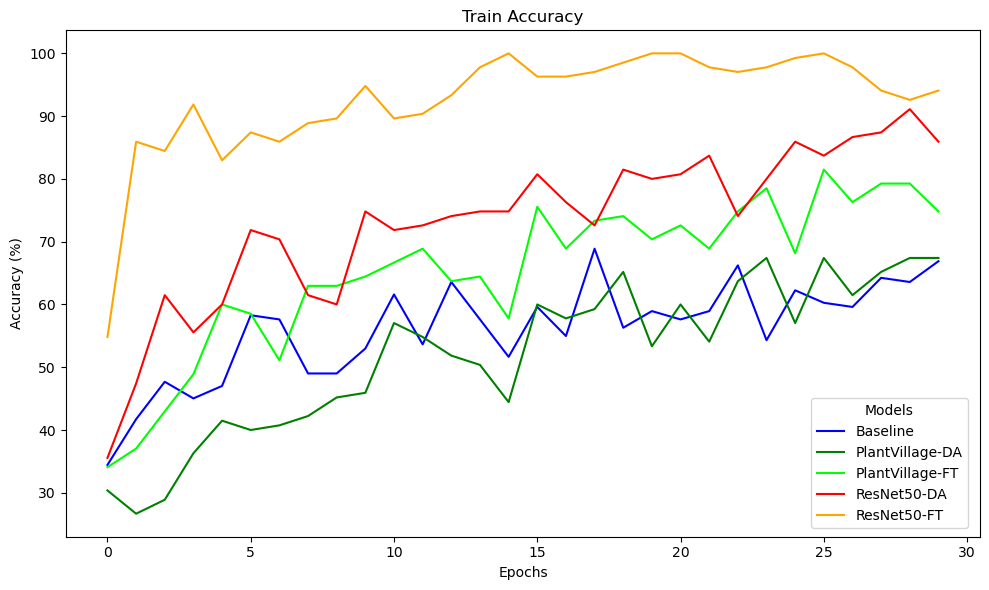

In [4]:
epochs = [i for i in range(30)]

fig = plt.figure(figsize=(10, 6))
plt.plot(epochs, baseline['train_acc'], color='blue')
plt.plot(epochs, plantvillage_da['train_acc'], color='green')
plt.plot(epochs, plantvillage_ft['train_acc'], color='lime')
plt.plot(epochs, resnet_da['train_acc'], color='red')
plt.plot(epochs, resnet_ft['train_acc'], color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train Accuracy')

names = ['Baseline', 'PlantVillage-DA', 'PlantVillage-FT', 'ResNet50-DA', 'ResNet50-FT']
colors = ['blue', 'green', 'lime', 'red', 'orange']

legend_elements = []
for color, name in zip(colors, names):
    legend_elements.append(Line2D([0], [0], label=name, linestyle='-', color=color))

fig.legend(
    handles=legend_elements,
    loc='lower right', 
    ncol=1,
    frameon=True,
    title='Models',
    bbox_to_anchor=(.98, 0.1)
)

plt.tight_layout()
plt.show()

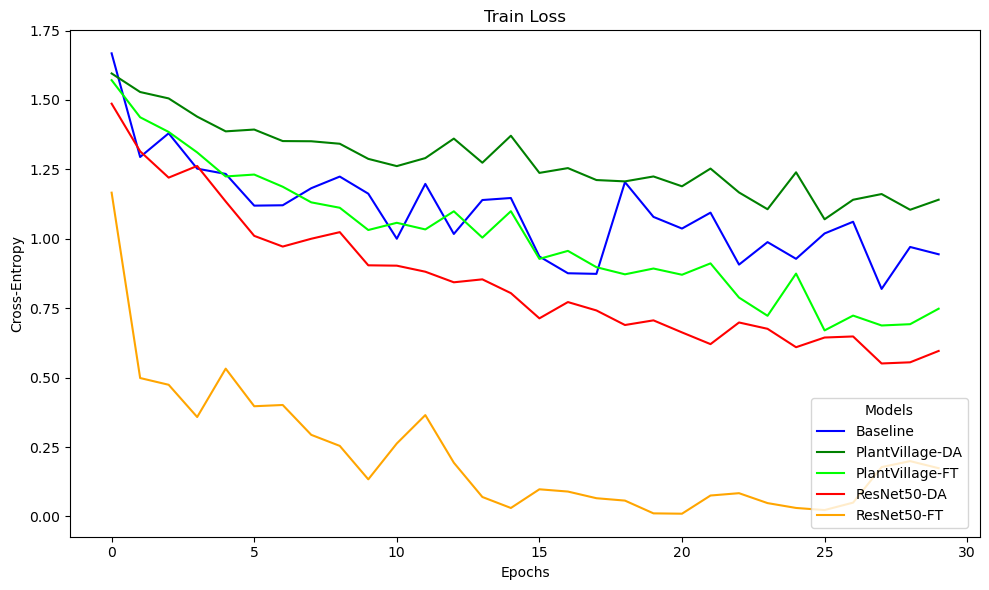

In [5]:
epochs = [i for i in range(30)]

fig = plt.figure(figsize=(10, 6))
plt.plot(epochs, baseline['train_loss'], color='blue')
plt.plot(epochs, plantvillage_da['train_loss'], color='green')
plt.plot(epochs, plantvillage_ft['train_loss'], color='lime')
plt.plot(epochs, resnet_da['train_loss'], color='red')
plt.plot(epochs, resnet_ft['train_loss'], color='orange')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.title('Train Loss')

names = ['Baseline', 'PlantVillage-DA', 'PlantVillage-FT', 'ResNet50-DA', 'ResNet50-FT']
colors = ['blue', 'green', 'lime', 'red', 'orange']

legend_elements = []
for color, name in zip(colors, names):
    legend_elements.append(Line2D([0], [0], label=name, linestyle='-', color=color))

fig.legend(
    handles=legend_elements,
    loc='lower right', 
    ncol=1,
    frameon=True,
    title='Models',
    bbox_to_anchor=(.98, 0.1)
)

plt.tight_layout()
plt.show()

## KFold

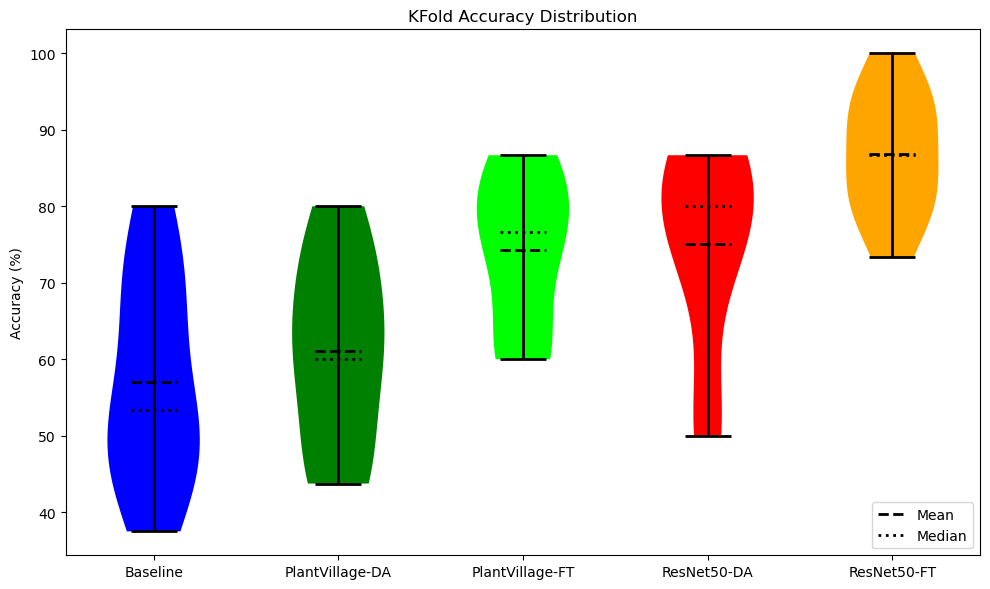

In [6]:
folds = [i for i in range(10)]
models = {
    'Baseline': baseline['kfold_acc'],
    'PlantVillage-DA': plantvillage_da['kfold_acc'],
    'PlantVillage-FT': plantvillage_ft['kfold_acc'],
    'ResNet50-DA': resnet_da['kfold_acc'],
    'ResNet50-FT': resnet_ft['kfold_acc']
}

colors = ['blue', 'green', 'lime', 'red', 'orange']

fig, ax = plt.subplots(figsize=(10, 6))

violin_parts = ax.violinplot(models.values(), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(1.)

for partname in ('cmeans',):
    vp = violin_parts[partname]
    vp.set_color('black')     
    vp.set_linestyle('--') 
    vp.set_linewidth(2)

for partname in ('cmedians',):
    vp = violin_parts[partname]
    vp.set_color('black')     
    vp.set_linestyle('dotted') 
    vp.set_linewidth(2)

for partname in ('cbars',):
    vp = violin_parts[partname]
    vp.set_color('black')

for partname in ('cmins', 'cmaxes', 'cbars'):
    vp = violin_parts[partname]
    vp.set_color('black')
    vp.set_linewidth(2)

ax.set_xticks(range(1, len(models)+1))
ax.set_xticklabels(models.keys())
ax.set_ylabel('Accuracy (%)')
ax.set_title('KFold Accuracy Distribution')

legend_elements = [
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Mean'),
    Line2D([0], [0], color='black', linestyle='dotted', linewidth=2, label='Median'),
]
ax.legend(handles=legend_elements, loc='lower right', frameon=True)

plt.tight_layout()
plt.show()

## Hypothesis Test

Kruscal test.

In [7]:
model_dict = {
    'Baseline': baseline['kfold_acc'],
    'PlantVillage-DA': plantvillage_da['kfold_acc'],
    'PlantVillage-FT': plantvillage_ft['kfold_acc'], 
    'ResNet50-DA': resnet_da['kfold_acc'],
    'ResNet50-FT': resnet_ft['kfold_acc'], 
}

stat, pvalue = stats.kruskal(*list(model_dict.values()))
print(f'p-value: {pvalue}')

p-value: 5.6343606375518285e-05


Dunn post-hoc.

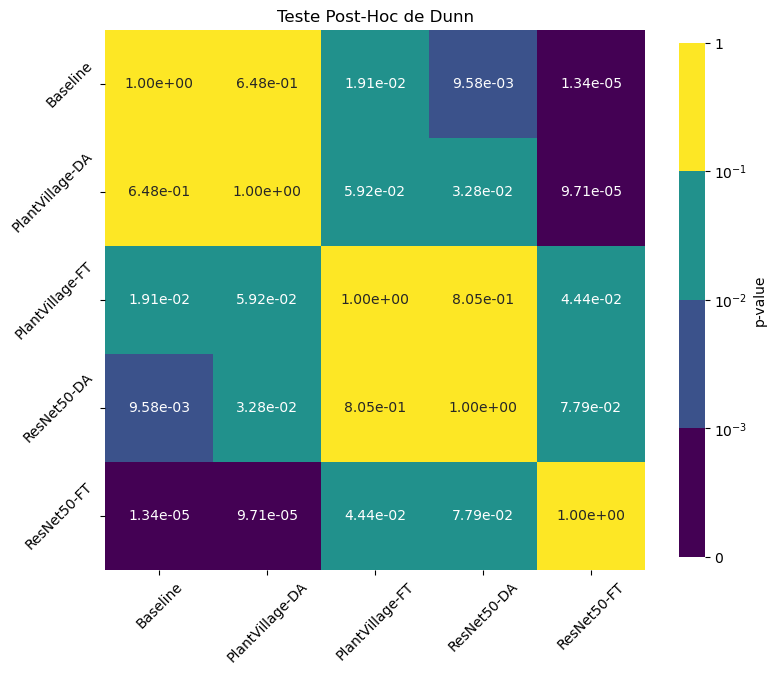

In [8]:
alpha = 0.05

bounds = [0, 0.001, 0.01, 0.1, 1.0]  
colors = ['#440154', '#3b528b', '#21918c', '#fde725'] 
cmap_discrete = ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap_discrete.N)

pvalue_matrix = sp.posthoc_dunn(list(model_dict.values()))

plt.figure(figsize=(8, 8))

ax = sns.heatmap(
    pvalue_matrix,
    annot=True, 
    fmt=".2e",   
    cmap=cmap_discrete,
    norm=norm,
    square=True, 
    xticklabels=list(model_dict.keys()),
    yticklabels=list(model_dict.keys()),
    cbar_kws={
        'label': 'p-value',
        'shrink': 0.7,
        'format': '%.3f'
    },
)

cbar = ax.collections[0].colorbar
cbar.set_ticklabels([r'$0$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$1$'])

plt.title('Teste Post-Hoc de Dunn')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

## Metrics

### Baseline

In [9]:
STUDY_NAME = 'milho_baseline'
study = optuna.load_study(study_name=STUDY_NAME, storage=f'sqlite:///hp_tuning/{STUDY_NAME}.db')

df = pd.read_csv(f'cross_validation/{STUDY_NAME}.csv')
columns = df.filter(like="Cross_Val")
df['Mean'] = columns.mean(axis=1)
df = df.drop(columns="Unnamed: 0")
df = df.sort_values(by=["Mean"], ascending=False)
df = df.reset_index(drop=True)

best_trial_num = df["Number"][0]
best_trial = study.get_trials()[best_trial_num]
kfold_acc = [df[f'Cross_Val_{i}'][0].item() for i in range(10)]

model_baseline = objective(
    best_trial,
    None,
    None,
    device='cpu',
    instantiate=True
)

model_baseline.load_state_dict(baseline['model'])

with torch.no_grad():
    y_pred_baseline = model_baseline(x_test)
    y_pred_labels = np.argmax(y_pred_baseline, axis=1)

report = classification_report(
    y_test.numpy(), 
    y_pred_labels.numpy(), 
    target_names=np.unique(names_test),
    zero_division=0
)

print(report)

                          precision    recall  f1-score   support

milho_ferrugem_polissora       0.40      1.00      0.57         2
  milho_mancha_bipolaris       0.50      0.40      0.44         5
     milho_mancha_branca       0.00      0.00      0.00         4
   milho_mancha_turcicum       0.75      1.00      0.86         3
          milho_saudavel       0.75      1.00      0.86         3

                accuracy                           0.59        17
               macro avg       0.48      0.68      0.55        17
            weighted avg       0.46      0.59      0.50        17



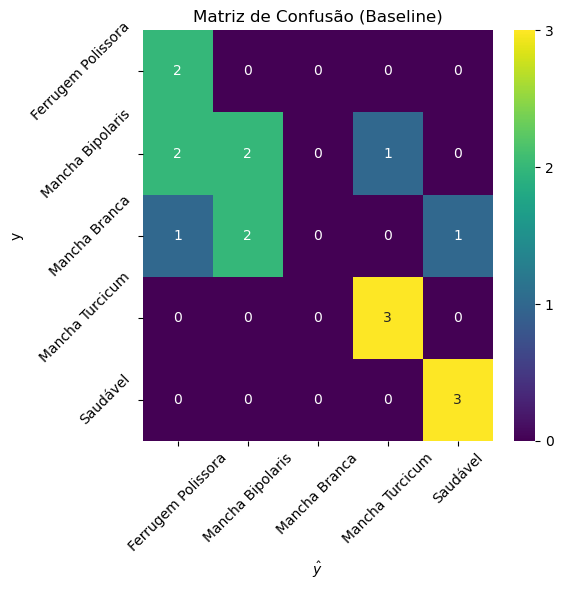

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='viridis',
    xticklabels=['Ferrugem Polissora', 'Mancha Bipolaris', 'Mancha Branca', 'Mancha Turcicum', 'Saudável'],
    yticklabels=['Ferrugem Polissora', 'Mancha Bipolaris', 'Mancha Branca', 'Mancha Turcicum', 'Saudável'],
    cbar_kws={'ticks': [0, 1, 2, 3]}
)
plt.title('Matriz de Confusão (Baseline)')
plt.ylabel(r'y')
plt.xlabel(r'$\hat y$')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

### PlantVillage-DA

In [11]:
STUDY_NAME = 'plantvillage'
study = optuna.load_study(study_name=STUDY_NAME, storage=f'sqlite:///../plantvillage/hp_tuning/{STUDY_NAME}.db')

df = pd.read_csv(f'../plantvillage/cross_validation/{STUDY_NAME}.csv')
columns = df.filter(like="Cross_Val")
df['Mean'] = columns.mean(axis=1)
df = df.drop(columns="Unnamed: 0")
df = df.sort_values(by=["Mean"], ascending=False)
df = df.reset_index(drop=True)

best_trial_num = df["Number"][0]
best_trial = study.get_trials()[best_trial_num]

n_classes = 5

model_plantvillage_da = CNNTransferLearning(best_trial, n_classes=n_classes, device='cpu')
model_plantvillage_da.load_state_dict(plantvillage_da['model'])

with torch.no_grad():
    y_pred_plantvillage_da = model_plantvillage_da(x_test)
    y_pred_labels = np.argmax(y_pred_plantvillage_da, axis=1)

report = classification_report(
    y_test.numpy(), 
    y_pred_labels.numpy(), 
    target_names=np.unique(names_test),
    zero_division=0
)

print(report)

                          precision    recall  f1-score   support

milho_ferrugem_polissora       0.00      0.00      0.00         2
  milho_mancha_bipolaris       0.57      0.80      0.67         5
     milho_mancha_branca       0.00      0.00      0.00         4
   milho_mancha_turcicum       0.75      1.00      0.86         3
          milho_saudavel       0.60      1.00      0.75         3

                accuracy                           0.59        17
               macro avg       0.38      0.56      0.45        17
            weighted avg       0.41      0.59      0.48        17



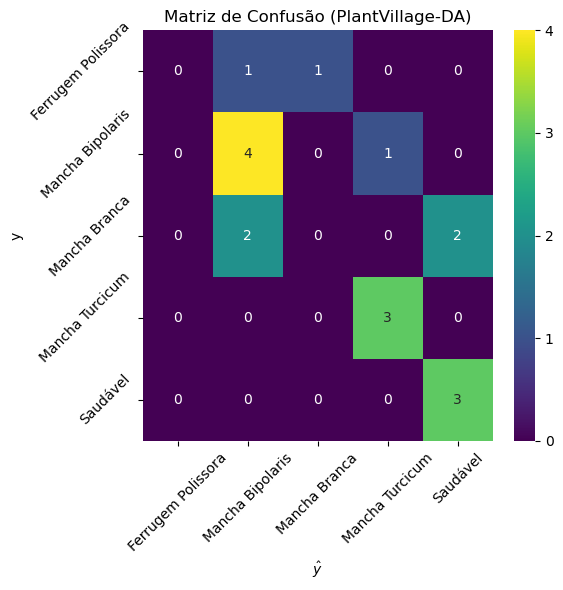

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='viridis',
    xticklabels=['Ferrugem Polissora', 'Mancha Bipolaris', 'Mancha Branca', 'Mancha Turcicum', 'Saudável'],
    yticklabels=['Ferrugem Polissora', 'Mancha Bipolaris', 'Mancha Branca', 'Mancha Turcicum', 'Saudável'],
    cbar_kws={'ticks': [0, 1, 2, 3, 4]}
)
plt.title('Matriz de Confusão (PlantVillage-DA)')
plt.ylabel(r'y')
plt.xlabel(r'$\hat y$')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

### PlantVillage-FT

In [13]:
STUDY_NAME = 'plantvillage'
study = optuna.load_study(study_name=STUDY_NAME, storage=f'sqlite:///../plantvillage/hp_tuning/{STUDY_NAME}.db')

df = pd.read_csv(f'../plantvillage/cross_validation/{STUDY_NAME}.csv')
columns = df.filter(like="Cross_Val")
df['Mean'] = columns.mean(axis=1)
df = df.drop(columns="Unnamed: 0")
df = df.sort_values(by=["Mean"], ascending=False)
df = df.reset_index(drop=True)

best_trial_num = df["Number"][0]
best_trial = study.get_trials()[best_trial_num]

n_classes = 5

model_plantvillage_ft = CNNTransferLearning(best_trial, n_classes=n_classes, device='cpu')
model_plantvillage_ft.load_state_dict(plantvillage_ft['model'])

with torch.no_grad():
    y_pred_plantvillage_ft = model_plantvillage_ft(x_test)
    y_pred_labels = np.argmax(y_pred_plantvillage_ft, axis=1)

report = classification_report(
    y_test.numpy(), 
    y_pred_labels.numpy(), 
    target_names=np.unique(names_test),
    zero_division=0
)

print(report)

                          precision    recall  f1-score   support

milho_ferrugem_polissora       0.50      0.50      0.50         2
  milho_mancha_bipolaris       0.83      1.00      0.91         5
     milho_mancha_branca       0.00      0.00      0.00         4
   milho_mancha_turcicum       1.00      1.00      1.00         3
          milho_saudavel       0.60      1.00      0.75         3

                accuracy                           0.71        17
               macro avg       0.59      0.70      0.63        17
            weighted avg       0.59      0.71      0.64        17



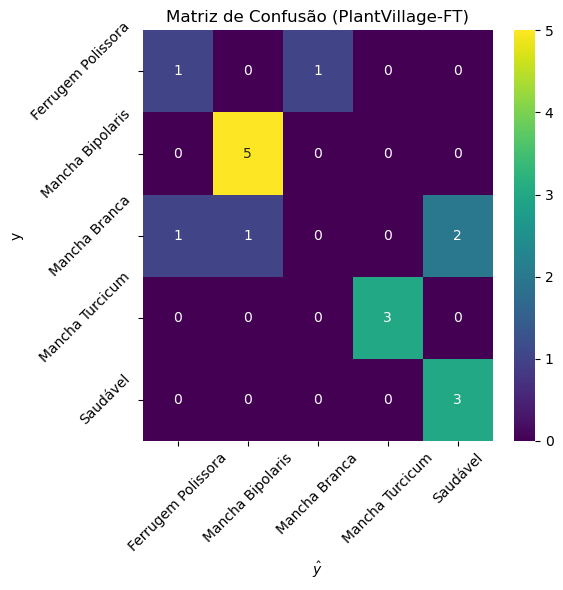

In [14]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='viridis',
    xticklabels=['Ferrugem Polissora', 'Mancha Bipolaris', 'Mancha Branca', 'Mancha Turcicum', 'Saudável'],
    yticklabels=['Ferrugem Polissora', 'Mancha Bipolaris', 'Mancha Branca', 'Mancha Turcicum', 'Saudável'],
    cbar_kws={'ticks': [0, 1, 2, 3, 4, 5]}
)
plt.title('Matriz de Confusão (PlantVillage-FT)')
plt.ylabel(r'y')
plt.xlabel(r'$\hat y$')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

### ResNet50-DA

In [15]:
n_classes = 5
model_resnet_da = ResNet(n_classes=n_classes)
model_resnet_da.load_state_dict(resnet_da['model'])

with torch.no_grad():
    y_pred_resnet_da = model_resnet_da(x_test)
    y_pred_labels = np.argmax(y_pred_resnet_da, axis=1)

report = classification_report(
    y_test.numpy(), 
    y_pred_labels.numpy(), 
    target_names=np.unique(names_test),
    zero_division=0
)

print(report)

                          precision    recall  f1-score   support

milho_ferrugem_polissora       0.00      0.00      0.00         2
  milho_mancha_bipolaris       1.00      1.00      1.00         5
     milho_mancha_branca       0.75      0.75      0.75         4
   milho_mancha_turcicum       1.00      1.00      1.00         3
          milho_saudavel       0.60      1.00      0.75         3

                accuracy                           0.82        17
               macro avg       0.67      0.75      0.70        17
            weighted avg       0.75      0.82      0.78        17



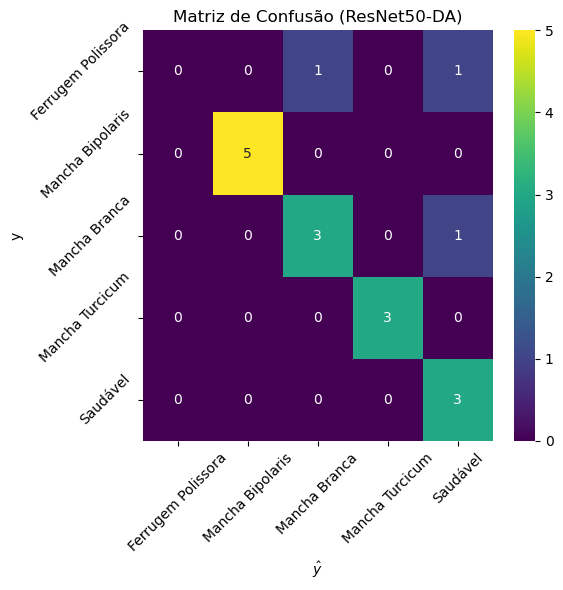

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='viridis',
    xticklabels=['Ferrugem Polissora', 'Mancha Bipolaris', 'Mancha Branca', 'Mancha Turcicum', 'Saudável'],
    yticklabels=['Ferrugem Polissora', 'Mancha Bipolaris', 'Mancha Branca', 'Mancha Turcicum', 'Saudável'],
    cbar_kws={'ticks': [0, 1, 2, 3, 4, 5]}
)
plt.title('Matriz de Confusão (ResNet50-DA)')
plt.ylabel(r'y')
plt.xlabel(r'$\hat y$')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

### ResNet50-FT

In [17]:
n_classes = 5
model_resnet_ft = ResNet(n_classes=n_classes)
model_resnet_ft.load_state_dict(resnet_ft['model'])

with torch.no_grad():
    y_pred_resnet_ft = model_resnet_ft(x_test)
    y_pred_labels = np.argmax(y_pred_resnet_ft, axis=1)

report = classification_report(
    y_test.numpy(), 
    y_pred_labels.numpy(), 
    target_names=np.unique(names_test),
)

print(report)

                          precision    recall  f1-score   support

milho_ferrugem_polissora       1.00      1.00      1.00         2
  milho_mancha_bipolaris       1.00      0.80      0.89         5
     milho_mancha_branca       1.00      1.00      1.00         4
   milho_mancha_turcicum       0.75      1.00      0.86         3
          milho_saudavel       1.00      1.00      1.00         3

                accuracy                           0.94        17
               macro avg       0.95      0.96      0.95        17
            weighted avg       0.96      0.94      0.94        17



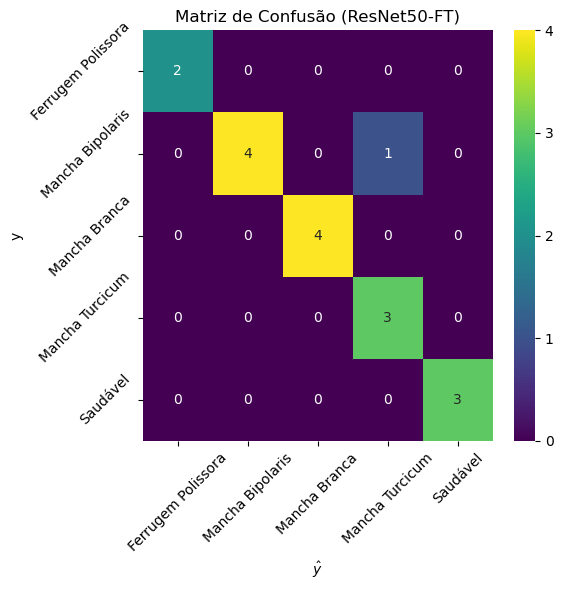

In [18]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(6, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='viridis',
    xticklabels=['Ferrugem Polissora', 'Mancha Bipolaris', 'Mancha Branca', 'Mancha Turcicum', 'Saudável'],
    yticklabels=['Ferrugem Polissora', 'Mancha Bipolaris', 'Mancha Branca', 'Mancha Turcicum', 'Saudável'],
    cbar_kws={'ticks': [0, 1, 2, 3, 4, 5]}
)
plt.title('Matriz de Confusão (ResNet50-FT)')
plt.ylabel(r'y')
plt.xlabel(r'$\hat y$')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()